In [3]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = torchvision.datasets.MNIST('./mnistdata', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30, shuffle=True, num_workers=2)

# load test set 

testset = torchvision.datasets.MNIST('./mnistdata', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=30, shuffle=False, num_workers=2)



Extracting ./mnistdata/MNIST/raw/train-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw


Extracting ./mnistdata/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw


Extracting ./mnistdata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw




Extracting ./mnistdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([30, 1, 28, 28])
torch.Size([30])


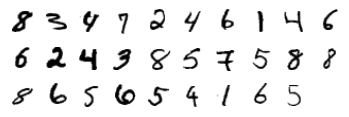

In [5]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
import torch.nn as nn

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

Epoch 0 - Training loss: 0.4727771483678371
Epoch 1 - Training loss: 0.2092233021967113
Epoch 2 - Training loss: 0.14875147559412288
Epoch 3 - Training loss: 0.1177064588512294
Epoch 4 - Training loss: 0.09775036626006477
Epoch 5 - Training loss: 0.08253726136818296
Epoch 6 - Training loss: 0.07129170254484052
Epoch 7 - Training loss: 0.06412698016240029
Epoch 8 - Training loss: 0.05709131916047772
Epoch 9 - Training loss: 0.0500890893941978
Epoch 10 - Training loss: 0.04524116257026617
Epoch 11 - Training loss: 0.042646278531072314
Epoch 12 - Training loss: 0.03740520329625724
Epoch 13 - Training loss: 0.0355672784100243
Epoch 14 - Training loss: 0.03168555110838861


In [10]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


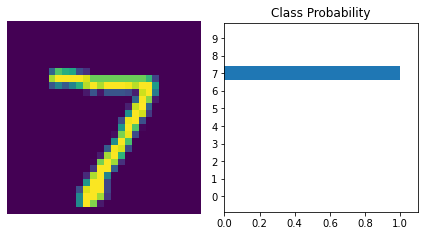

In [11]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.cpu().view(1, 28, 28), ps)

In [12]:

correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9753


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def img_show(img):
  img = img / 2 + 0.5  # un-normalize (mean = 0.5, std = 0.5)
  np_img = image.cpu().resize_(1, 28, 28).numpy().squeeze()
  plt.imshow(np_img, cmap='gray_r')
  plt.show()

In [54]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image

def inversion(model, label):
  iteration = 4000
  x = torch.zeros(1, 28, 28) # initialization
  x = Variable(x.cuda().view(1, 784), requires_grad=True)
  model.zero_grad()
  for i in range(iteration):
    out = model(x)
    loss = out.take(label)
    loss.backward()
    x.data = x.data - 0.1 * x.grad.data
    x.grad.zero_()
  x = x.data.squeeze()
  recon_img = x.cpu().resize_(1, 28, 28).numpy().squeeze()
  return recon_img


Actual Image


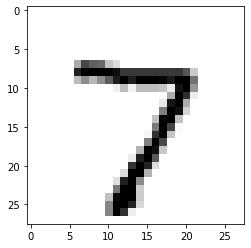

Reconstructed Image


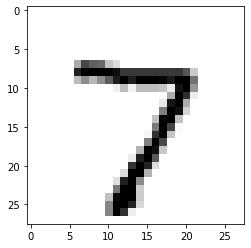

Actual Image


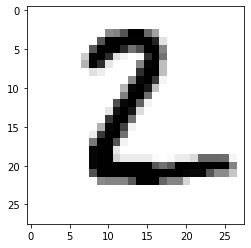

Reconstructed Image


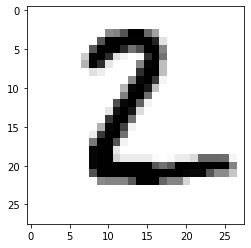

Actual Image


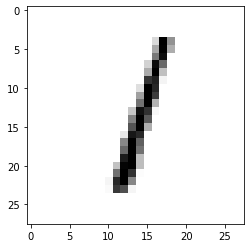

Reconstructed Image


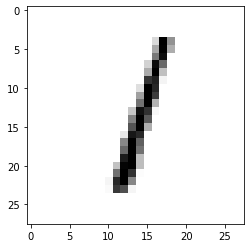

Actual Image


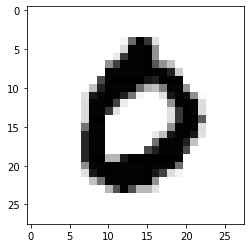

Reconstructed Image


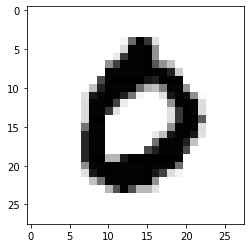

Actual Image


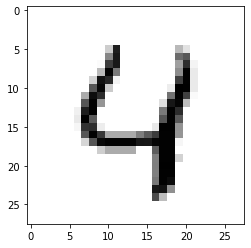

Reconstructed Image


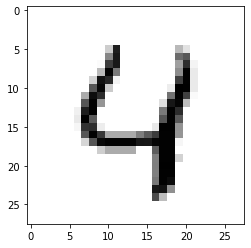

In [56]:
testdata_iter = iter(testloader)
images, labels = testdata_iter.next()
images, labels = images.to(device), labels.to(device)

image = images[0]
label = labels[0]

for i in range(5):
  image = images[i]
  label = labels[i]

  print("Actual Image")
  actual_image = image.cpu().resize_(1, 28, 28).numpy().squeeze()
  img_show(actual_image)

  print("Reconstructed Image")
  recon_img = inversion(model.to(device), label)
  img_show(recon_img)
